# API Demo and Testing
Notebook to demonstrate API use case and unit testing.

In [1]:
import requests
import random
#!pip install matplotlib
import matplotlib.pyplot as plt

In [2]:
# Define MODELS global variable for testing
with open('api/resources/accepted_models.txt') as f:
    MODELS = [line.strip() for line in f.readlines()]

In [3]:
# Define URL
url = 'http://127.0.0.1:5000/' # -> USE THIS TO TEST LOCAL APPLICATION
#url = 'http://127.0.0.1:8080/'  # -> USE THIS TO TEST DOCKER IMAGE

### /inference

**POST**: Performs mask inference with given string against a HuggingFace model. Returns a list of JSON objects containing a probability score, a token string (value to fill in [MASK]), and the original string with [MASK] replaced.


In [4]:
#### Test 1: Payloads

# Define payload list
payloads = [
    {'model': 'bert-base-uncased'},    # Expecting 500; 'input' not found in payload
    {'input': "Hello I'm a [MASK] model.", 'model': 'not-a-model'}, # Expecting 500; not a valid 'model'
    {'input': "Hello I'm a model.", 'model': 'bert-base-uncased'}, # Expecting 500; 'input' must contain [MASK] or <mask> token
    {'input': "Hello I'm a [MASK] model.", 'model': 'bert-base-uncased'}, # Expecting 201; valid payload
    {'input': "Hello I'm a <mask> model.", 'model': 'bert-base-uncased'}, # Expecting 201; valid payload (<mask> converted to [MASK])
    {'input': "Hello I'm a <mask> model.", 'model': 'roberta-base'}, # Expecting 201; valid payload
    {'input': "Hello I'm a [MASK] model.", 'model': 'roberta-base'}, # Expecting 201; valid payload ([MASK] converted to <mask>)
    {'input': "Hello I'm a [MASK] model."} # Expecting 201; defaults to 'bert-base-uncased'
]

# Define expected status codes
true_status = [500, 500, 500, 201, 201, 201, 201]

# Run tests
for p, s in list(zip(payloads, true_status)):
    # POST request
    res = requests.post(url + 'inference', json = p)

    # Assert truth
    assert res.status_code == s

    # Print json output
    print(p, ':')
    print('\t', res.json())
    print()
    print()

{'model': 'bert-base-uncased'} :
	 {'message': 'ValueError: input string is required.'}


{'input': "Hello I'm a [MASK] model.", 'model': 'not-a-model'} :
	 {'message': "ValueError: model is not accepted. Please select from the following: ['bert-base-uncased', 'distilbert-base-uncased', 'roberta-base', 'roberta-large', 'xlm-roberta-base']."}


{'input': "Hello I'm a model.", 'model': 'bert-base-uncased'} :
	 {'message': 'ValueError: input must contain [MASK] or <mask> tokens.'}


{'input': "Hello I'm a [MASK] model.", 'model': 'bert-base-uncased'} :
	 {'data': [{'score': 0.1073109433054924, 'token': 4827, 'token_str': 'fashion', 'sequence': "hello i'm a fashion model."}, {'score': 0.08774474263191223, 'token': 2535, 'token_str': 'role', 'sequence': "hello i'm a role model."}, {'score': 0.05338391289114952, 'token': 2047, 'token_str': 'new', 'sequence': "hello i'm a new model."}, {'score': 0.04667219892144203, 'token': 3565, 'token_str': 'super', 'sequence': "hello i'm a super model."},

bert-base-uncased :
	 {'data': [{'score': 0.1073109433054924, 'token': 4827, 'token_str': 'fashion', 'sequence': "hello i'm a fashion model."}, {'score': 0.08774474263191223, 'token': 2535, 'token_str': 'role', 'sequence': "hello i'm a role model."}, {'score': 0.05338391289114952, 'token': 2047, 'token_str': 'new', 'sequence': "hello i'm a new model."}, {'score': 0.04667219892144203, 'token': 3565, 'token_str': 'super', 'sequence': "hello i'm a super model."}, {'score': 0.027095891535282135, 'token': 2986, 'token_str': 'fine', 'sequence': "hello i'm a fine model."}], 'inference_time': 0.09723}


distilbert-base-uncased :
	 {'data': [{'score': 0.05292866751551628, 'token': 2535, 'token_str': 'role', 'sequence': "hello i'm a role model."}, {'score': 0.03968580439686775, 'token': 4827, 'token_str': 'fashion', 'sequence': "hello i'm a fashion model."}, {'score': 0.034743692725896835, 'token': 2449, 'token_str': 'business', 'sequence': "hello i'm a business model."}, {'score': 0.03462289646

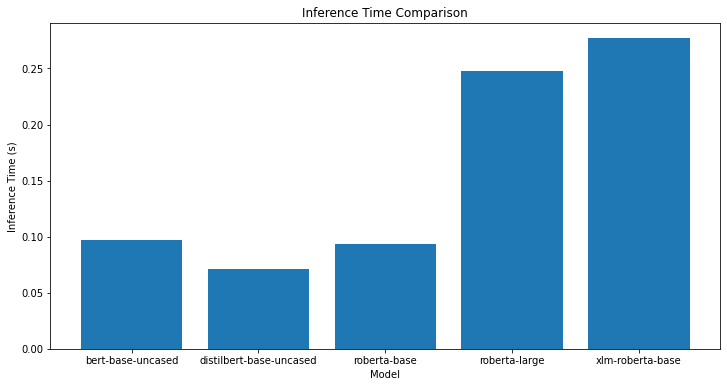

In [5]:
#### Test 2: Checking model output + 'inference_time' chart (example use case of response)

# Define universal payload object
payload = {'input': "Hello I'm a [MASK] model."}

# Run tests
inf_time = dict()

for m in MODELS:
    # Update payload
    payload['model'] = m

    # Post request
    res = requests.post(url + 'inference', json = payload)

    # Assert truth
    assert res.status_code == 201

    # Collect inference time
    inf_time[m] = res.json()['inference_time']

    # Print json output
    print(m, ':')
    print('\t', res.json())
    print()
    print()

# Compare inference times between models
plt.figure(figsize=(12,6))
plt.bar(range(len(inf_time)), list(inf_time.values()), tick_label=list(inf_time.keys()))
plt.title('Inference Time Comparison')
plt.xlabel('Model')
plt.ylabel('Inference Time (s)')
plt.show()


In [6]:
#### Test 3: Checking other random strings for inference output

# Define 'random' input 
rand_input = ['[MASK] are my favorite animals!', 'Did you see <mask> at the store?', 'This is a very long string. It is being tested to see what the [MASK] should be. Hopefully it works!']

# Define 'random' models
rand_models = random.sample(MODELS, len(rand_input))

# Run tests
for i, m in list(zip(rand_input, rand_models)):
    # Define payload object
    payload = {'input': i, 'model': m}

    # POST request
    res = requests.post(url + 'inference', json = payload)

    # Assert truth
    assert res.status_code == 201

    # Print json output
    print(i, '+', m, ':')
    print('\t', res.json())
    print()
    print()

[MASK] are my favorite animals! + xlm-roberta-base :
	 {'data': [{'score': 0.5557931661605835, 'token': 11853, 'token_str': 'Here', 'sequence': 'Here are my favorite animals!'}, {'score': 0.380218505859375, 'token': 32255, 'token_str': 'These', 'sequence': 'These are my favorite animals!'}, {'score': 0.013871505856513977, 'token': 139661, 'token_str': 'Those', 'sequence': 'Those are my favorite animals!'}, {'score': 0.010785228572785854, 'token': 10660, 'token_str': 'They', 'sequence': 'They are my favorite animals!'}, {'score': 0.0057411170564591885, 'token': 6097, 'token_str': 'these', 'sequence': 'these are my favorite animals!'}], 'inference_time': 0.2106}


Did you see <mask> at the store? + bert-base-uncased :
	 {'data': [{'score': 0.3880321681499481, 'token': 2014, 'token_str': 'her', 'sequence': 'did you see her at the store?'}, {'score': 0.25028595328330994, 'token': 2032, 'token_str': 'him', 'sequence': 'did you see him at the store?'}, {'score': 0.0439034104347229, 'token': 

### /inference/models

**GET**: Lists the HuggingFace inference models (formatted as expected in the POST payload) currently supported by the API, as outlined in **api/resources/accepted_models.txt**.

In [7]:
# Test 1: inference/models endpoint with GET request
res = requests.get(url + 'inference/models')

# Assert truth
assert res.status_code == 200

# Print JSON response
print('Response:', res.json())

# Compare against models
print()
print('Models List:', MODELS)

Response: {'models': ['bert-base-uncased', 'distilbert-base-uncased', 'roberta-base', 'roberta-large', 'xlm-roberta-base']}

Models List: ['bert-base-uncased', 'distilbert-base-uncased', 'roberta-base', 'roberta-large', 'xlm-roberta-base']


### /healthcheck

**GET**: Basic check to see if API is functioning. Returns a HTTP 200.
(Also supports **HEAD** request.)

In [8]:
#### Test 1: Validating healthcheck output

# GET request
get_res = requests.get(url + 'healthcheck')
assert get_res.status_code == 200
print(get_res.json())

# HEAD request
head_res = requests.head(url + 'healthcheck')
assert head_res.status_code == 200

HEALTHY


### /healthcheck/extracheck

**GET**: Extra check to see if HuggingFace models download page is functioning. Returns a HTTP 200 if healthy and HTTP 404 if unhealthy. (Also supports **HEAD** request.)

In [9]:
#### Test 1: Validating healthcheck/extracheck output

# GET request
get_res = requests.get(url + 'healthcheck/extracheck')
assert get_res.status_code == 200
print(get_res.json())

# HEAD request
head_res = requests.head(url + 'healthcheck/extracheck')
assert head_res.status_code == 200

HEALTHY
